# Computer vision - Age recognition from face image

We are using ResNet50 architecture with augmentations to build a regression model to predict age from image.

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import math
import seaborn as sns
from scipy.stats import shapiro

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
  
warnings.filterwarnings('ignore')

In [162]:
labels = pd.read_csv('C:/Users/vital/Downloads/appa-real-release/labels.csv')
path = 'C:/Users/vital/Downloads/appa-real-release/train/'

In [273]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

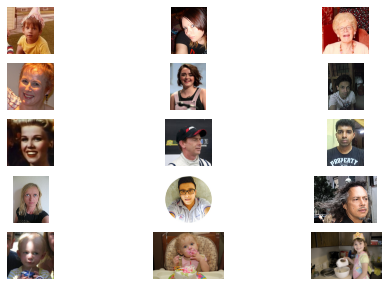

In [264]:
#Look our data
# Generate the subplots
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(8, 5, forward=True)

# Map each file to subplot
for i in range(0, 15):
    file_name = labels['file_name'][i]
    image = Image.open(f'{path}/{file_name}')
    row = math.floor(i / 3)
    col = i % 3
    axs[row, col].imshow(image)
    axs[row, col].axis('off')

# Show the plot
plt.show()

In [265]:
labels['real_age'].describe()

count    4113.000000
mean       30.476052
std        16.312428
min         1.000000
25%        19.000000
50%        28.000000
75%        40.000000
max       100.000000
Name: real_age, dtype: float64

We have people in the age range between 1 to 100, with mean age of 31 and median of 29.

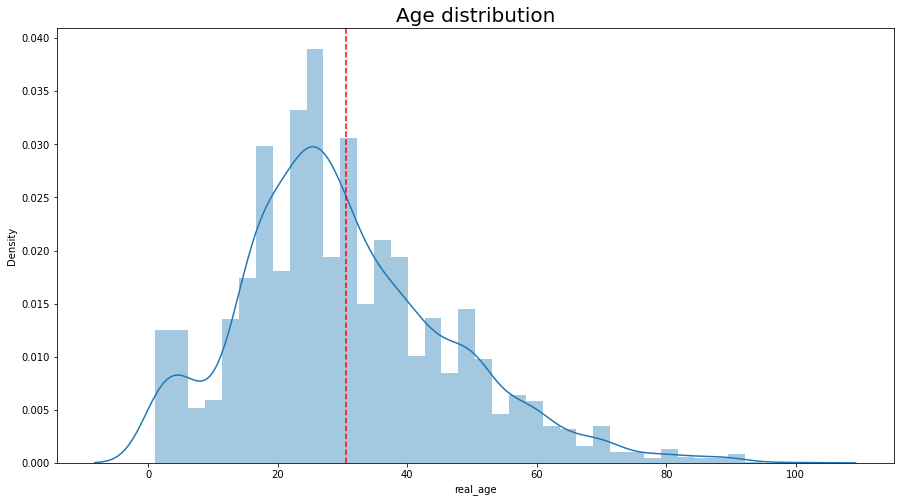

In [272]:
plt.figure(figsize = (15,8))
sns.distplot(labels['real_age'])
plt.title('Age distribution', size=20)
plt.axvline(labels['real_age'].mean(),c='red', ls='--')
plt.show()

The distribution of ages seems to be close to normal distribution.

In [269]:
#Exemine the normality of distribution with Shapiro test
alpha = 0.05

data = labels['real_age']

# normality test
stat, p = shapiro(data)

print('Statistics=%.3f, p=%.3f' % (stat, p))

if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=0.968, p=0.000
Sample does not look Gaussian (reject H0)


## Modelling

In [287]:
 train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25, horizontal_flip=True,
        rotation_range=20)

In [288]:
def load_train(path):

   
    train_gen_flow = train_datagen.flow_from_dataframe(directory = path, 
                                dataframe = labels ,target_size=(150,150),x_col='file_name', y_col='real_age',
                                batch_size=16, class_mode='raw',
                                subset='training', seed=12345,
                                                      shuffle=True)

    return train_gen_flow

def load_test(path):
    

    test_gen_flow = train_datagen.flow_from_dataframe(directory = path, 
                                                      dataframe = labels, target_size=(150,150),x_col='file_name', y_col='real_age',
                                batch_size=16,  class_mode='raw', shuffle=False,
                                subset='validation',seed=12345)

    return test_gen_flow

def create_model(input_shape=(150, 150, 3)):
    

    backbone = ResNet50(input_shape = input_shape, weights='imagenet',
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
        
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,validation_data=test_data,batch_size=batch_size,
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps)
    

    return model

In [275]:
train = load_train(path)

Found 3085 validated image filenames.


In [276]:
test = load_test(path)

Found 1028 validated image filenames.


In [166]:
model = create_model()

In [278]:
model.fit(train, validation_data=test, batch_size=None, epochs=5,steps_per_epoch = len(train),validation_steps = len(test))

Epoch 1/5
193/193 [==============================] - 1143s 6s/step - loss: 148.1976 - mae: 9.3312 - val_loss: 245.2469 - val_mae: 11.7696
Epoch 2/5
193/193 [==============================] - 1163s 6s/step - loss: 114.9321 - mae: 8.2784 - val_loss: 144.0790 - val_mae: 8.9872
Epoch 3/5
193/193 [==============================] - 1134s 6s/step - loss: 102.4072 - mae: 7.7522 - val_loss: 277.8579 - val_mae: 11.9553
Epoch 4/5
193/193 [==============================] - 1196s 6s/step - loss: 86.6188 - mae: 7.1252 - val_loss: 132.7670 - val_mae: 8.8786
Epoch 5/5
193/193 [==============================] - 1146s 6s/step - loss: 80.9584 - mae: 6.8741 - val_loss: 121.4095 - val_mae: 8.4782


In [279]:
#Save the model

# serialize to JSON
json_file = model.to_json()
with open('model_vision', "w") as file:
     file.write(json_file)
# serialize weights to HDF5
model.save_weights('weights')

In [280]:
from tensorflow.keras.models import model_from_json
# load json and create model
file = open('model_vision', 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)
# load weights
loaded_model.load_weights('weights')

In [281]:
#Upload photo for age orediction
new_datagen = ImageDataGenerator(rescale=1/255.)

In [282]:
new = new_datagen.flow_from_directory('C:/Users/vital/Downloads/new/', 
                                      target_size=(150,150),batch_size=16, class_mode=None,seed=12345)

Found 1 images belonging to 1 classes.


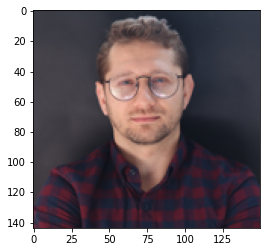

In [321]:
#Present the photo fpr age prediction
im = Image.open('C:/Users/vital/Downloads/new/images/vitalitest.jpg')
size = 150, 150
im.thumbnail(size)
plt.imshow(im);

In [286]:
pred = loaded_model.predict(new)
print(pred)

[[32.08765]]


My real age on Mar 17, 2022 is 34. 